In [14]:
import mahotas
import mahotas.features
from glob import glob
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from statannotations.Annotator import Annotator
import scipy.stats as ss
import statsmodels.api as sa
import scikit_posthocs as sp
from statsmodels.formula.api import ols
%matplotlib inline 

In [15]:
inDataDir = '210930_CellProfiler_Output'
outDataDir = '.'

In [21]:
images = {} 

images['DNA'] = glob(f'{inDataDir}/Nuclei_Images_DNA_slide*/*', recursive = True)

images['Top2A'] = []

for i in images['DNA']:
    images['Top2A'].append(i.replace('DNA', 'Top2A'))


In [24]:
#read in images

imported_images = {}

for stain in ['DNA', 'Top2A']:
    imported_images[stain] = {}
    for image in images[stain]:
        imported_images[stain][image] = mahotas.imread(image)

In [25]:
#stretch images to 256 levels each, min to max

stretched_images = {}

for stain in ['DNA', 'Top2A']:
    stretched_images[stain] = {}
    for image in images[stain]:
        stretched_images[stain][image] = mahotas.stretch(imported_images[stain][image])

In [27]:
image_features = pd.DataFrame()

for size in range(1, 25):
    image_features_df_dict = {}
    
    image_features_df_dict['DNA'] = pd.DataFrame()
    image_features_df_dict['Top2A'] = pd.DataFrame()
    
    for stain in ['DNA', 'Top2A']:
        image_features_df = pd.DataFrame()
        for image in images[stain]:
            df = pd.DataFrame(mahotas.features.haralick(stretched_images[stain][image], return_mean = True, distance = size, ignore_zeros = True)).transpose()
            df.columns = [
                f'AngularSecondMoment_{stain}',
                f'Contrast_{stain}',
                f'Correlation_{stain}',
                f'Variance_{stain}',
                f'InverseDifferenceMoment_{stain}',
                f'SumAverage_{stain}',
                f'SumVariance_{stain}',
                f'SumEntropy_{stain}',
                f'Entropy_{stain}',
                f'DifferenceVariance_{stain}',
                f'DifferenceEntropy_{stain}',
                f'InfoMeas1_{stain}',
                f'InfoMeas2_{stain}'
            ]
            df[f'ImagePath_{stain}'] = image
            df[f'Distance_{stain}'] = size
            #Split filename at /, then split SlideDir 
            df[['InputDir', 'ImageDir', 'FileName']] = df[f'ImagePath_{stain}'].str.split('/', expand=True).iloc[:, 0:3]
            df[['Stain', 'SlideNum', 'ImageNum']] = df['ImageDir'].str.split('_', expand = True).iloc[:, 2:5]

            #Add sample name for each nucleus based on slide number
            #Cell Line: HeLa S3 + Top2A-Venus, or HeLa S3 untagged

           #Samples :
            #1. Hela S3, untagged, t4 DMSO, unstained
            #2. HeLa S3, Top2A-Venus, t0 Mit, Lamin A + DAPI stain
            #3. HeLa S3, Top2A-Venus, t2, Lamin A + DAPI stain
            #4. HeLa S3, Top2A-Venus, t4 DMSO, Lamin A + DAPI stain
            #5. HeLa S3, Top2A-Venus, t4 ICRF, Lamin A + DAPI stain
            #6. HeLa S3, Top2A-Venus, t8 DMSO, Lamin A + DAPI stain
            #7. HeLa S3, Top2A-Venus, t8 ICRF, Lamin A + DAPI stain

            slidenum_samples = {
                'slide2' : 't0 Mitotic',
                'slide3' : 't2',
                'slide4' : 't4 DMSO',
                'slide5' : 't4 ICRF-193',
                'slide6' : 't8 DMSO',
                'slide7' : 't8 ICRF-193'
            }
            
            for slide in df['SlideNum'].unique():
                df.loc[df['SlideNum'] == slide, 'Sample'] = slidenum_samples[slide]

            image_features_df_dict[stain] = image_features_df_dict[stain].append(df)
            
    size_df = image_features_df_dict['DNA'].merge(image_features_df_dict['Top2A'], on = ['Sample', 'SlideNum', 'FileName', 'ImageNum'], suffixes = ('_DNA', '_Top2A'))
    image_features = image_features.append(size_df).reset_index(drop = True)

In [28]:
image_features[['ImageDir_DNA', 'ImageDir_Top2A', 'Sample', 'SlideNum', 'FileName', 'ImageNum']]

,ImageDir_DNA,ImageDir_Top2A,Sample,SlideNum,FileName,ImageNum
0,Nuclei_Images_DNA_slide2_013,Nuclei_Images_Top2A_slide2_013,t0 Mitotic,slide2,Nuclei_1.tiff,013
1,Nuclei_Images_DNA_slide2_014,Nuclei_Images_Top2A_slide2_014,t0 Mitotic,slide2,Nuclei_1.tiff,014
2,Nuclei_Images_DNA_slide3_040,Nuclei_Images_Top2A_slide3_040,t2,slide3,Nuclei_1.tiff,040
3,Nuclei_Images_DNA_slide3_014,Nuclei_Images_Top2A_slide3_014,t2,slide3,Nuclei_2.tiff,014
4,Nuclei_Images_DNA_slide3_014,Nuclei_Images_Top2A_slide3_014,t2,slide3,Nuclei_1.tiff,014
...,...,...,...,...,...,...
5971,Nuclei_Images_DNA_slide3_035,Nuclei_Images_Top2A_slide3_035,t2,slide3,Nuclei_2.tiff,035
5972,Nuclei_Images_DNA_slide3_035,Nuclei_Images_Top2A_slide3_035,t2,slide3,Nuclei_1.tiff,035
5973,Nuclei_Images_DNA_slide3_032,Nuclei_Images_Top2A_slide3_032,t2,slide3,Nuclei_3.tiff,032
5974,Nuclei_Images_DNA_slide3_032,Nuclei_Images_Top2A_slide3_032,t2,slide3,Nuclei_2.tiff,032


In [12]:
#https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0212110
#Probably better to scale from min to max of each image, as I was doing originally - otherwise
#have different number of grey levels per image, since not all the same intensity,
#which can affect the feature calculations.

In [29]:
image_features.columns

Index(['AngularSecondMoment_DNA', 'Contrast_DNA', 'Correlation_DNA',
       'Variance_DNA', 'InverseDifferenceMoment_DNA', 'SumAverage_DNA',
       'SumVariance_DNA', 'SumEntropy_DNA', 'Entropy_DNA',
       'DifferenceVariance_DNA', 'DifferenceEntropy_DNA', 'InfoMeas1_DNA',
       'InfoMeas2_DNA', 'ImagePath_DNA', 'Distance_DNA', 'InputDir_DNA',
       'ImageDir_DNA', 'FileName', 'Stain_DNA', 'SlideNum', 'ImageNum',
       'Sample', 'AngularSecondMoment_Top2A', 'Contrast_Top2A',
       'Correlation_Top2A', 'Variance_Top2A', 'InverseDifferenceMoment_Top2A',
       'SumAverage_Top2A', 'SumVariance_Top2A', 'SumEntropy_Top2A',
       'Entropy_Top2A', 'DifferenceVariance_Top2A', 'DifferenceEntropy_Top2A',
       'InfoMeas1_Top2A', 'InfoMeas2_Top2A', 'ImagePath_Top2A',
       'Distance_Top2A', 'InputDir_Top2A', 'ImageDir_Top2A', 'Stain_Top2A'],
      dtype='object')

<AxesSubplot:xlabel='Contrast_DNA', ylabel='Contrast_Top2A'>

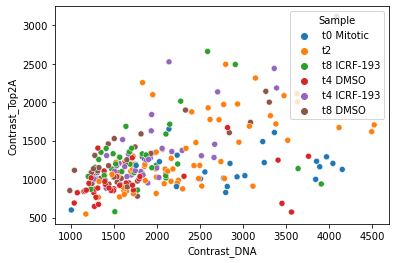

In [30]:
sns.scatterplot(data = image_features[image_features['Distance_DNA'] == 10], 
                x = 'Contrast_DNA', 
                y = 'Contrast_Top2A',
                hue = 'Sample'
               )

In [31]:
#Add Lamin A and nuclear size/shape info to each object

In [32]:
cytoplasm = pd.read_csv(f'{inDataDir}/210930_DNAAndTop2A_SaveCropped_Texture_256levelsCytoplasm.csv')
nuclei = pd.read_csv(f'{inDataDir}/210930_DNAAndTop2A_SaveCropped_Texture_256levelsExpandedNuclei_2pixels.csv')

In [33]:
#Add cytoplasm LaminA intensity to each nucleus - should be fine to just add by index, since 
#should be in same order and 1:1 correspondance.
nuclei['Cytoplasm_Intensity_MeanIntensity_LaminA'] = cytoplasm['Intensity_MeanIntensity_LaminA']

In [34]:
nuclei['Nuc_Cyt_LaminA_Ratio'] = nuclei['Intensity_MeanIntensity_LaminA']/nuclei['Cytoplasm_Intensity_MeanIntensity_LaminA']

In [37]:
#Split filename at /, then split SlideDir 
nuclei[['Metadata_Experiment', 'SlideNum', 'ImageNum']] = nuclei['FileName_DNA'].str.split('_', expand = True).iloc[:, 1:4]
image_features['ObjectNumber'] = image_features['FileName'].str.split('_', expand = True).iloc[:, 1].str.split('.', expand = True).iloc[:, 0]

In [38]:
nuclei[['SlideNum', 'ImageNum', 'Metadata_Experiment', 'ObjectNumber', 'Nuc_Cyt_LaminA_Ratio']]

,SlideNum,ImageNum,Metadata_Experiment,ObjectNumber,Nuc_Cyt_LaminA_Ratio
0,slide2,001,exp508,1,0.970116
1,slide2,002,exp508,1,0.374804
2,slide2,002,exp508,2,0.793337
3,slide2,003,exp508,1,1.829667
4,slide2,004,exp508,1,1.717248
...,...,...,...,...,...
244,slide7,027,exp508,1,4.793433
245,slide7,028,exp508,1,3.903733
246,slide7,029,exp508,1,3.734627
247,slide7,030,exp508,1,5.428487


In [39]:
image_features[['SlideNum', 'ImageNum', 'FileName', 'ObjectNumber']]

,SlideNum,ImageNum,FileName,ObjectNumber
0,slide2,013,Nuclei_1.tiff,1
1,slide2,014,Nuclei_1.tiff,1
2,slide3,040,Nuclei_1.tiff,1
3,slide3,014,Nuclei_2.tiff,2
4,slide3,014,Nuclei_1.tiff,1
...,...,...,...,...
5971,slide3,035,Nuclei_2.tiff,2
5972,slide3,035,Nuclei_1.tiff,1
5973,slide3,032,Nuclei_3.tiff,3
5974,slide3,032,Nuclei_2.tiff,2


In [41]:
image_features = image_features.astype({'ObjectNumber': 'int64'})

In [42]:
#Add nuclei['Nuc_Cyt_LaminA_Ratio'] to image_features
image_features2 = image_features.merge(nuclei[['SlideNum', 'ImageNum', 'ObjectNumber', 'Metadata_Experiment', 'Nuc_Cyt_LaminA_Ratio']], on = ['SlideNum', 'ImageNum', 'ObjectNumber'])


In [43]:
image_features = image_features2

In [44]:
image_features = image_features.drop_duplicates().reset_index(drop = True)

In [45]:
#Find nuclei with contrast near median for each sample to show as representative examples
representative_images_means = image_features.groupby(['Sample', 'Distance_DNA']).agg('median')

In [46]:
representative_images_means

AngularSecondMoment_DNA  Contrast_DNA  \
Sample      Distance_DNA                                          
t0 Mitotic  1                            0.000233    142.751948   
            2                            0.000169    409.884514   
            3                            0.000135    769.217489   
            4                            0.000123   1139.194715   
            5                            0.000115   1505.460653   
...                                           ...           ...   
t8 ICRF-193 20                           0.000170   2139.174044   
            21                           0.000171   2166.561278   
            22                           0.000173   2171.480489   
            23                           0.000174   2166.074816   
            24                           0.000175   2182.057962   

                          Correlation_DNA  Variance_DNA  \
Sample      Distance_DNA                                  
t0 Mitotic  1                    0.957642   1757.489209   
            2                    0.879443   1719.004696   
            3                    0.778051   1699.139642   
            4                    0.667563   1689.389160   
            5                    0.556149   1685.864649   
...                                   ...           ...   
t8 ICRF-193 20                   0.014327   1097.678523   
            21                   0.013437   1100.992887   
            22                   0.008057   1104.340692   
            23                   0.005895   1108.039607   
            24                  -0.002125   1111.796426   

                          InverseDifferenceMoment_DNA  SumAverage_DNA  \
Sample      Distance_DNA                                                
t0 Mitotic  1                                0.113095      266.457182   
            2                                0.066723      267.942427   
            3                                0.050307      268.999747   
            4                                0.040797      269.651717   
            5                                0.035336      269.978746   
...                                               ...             ...   
t8 ICRF-193 20                               0.027124      277.354203   
            21                               0.027010      277.357104   
            22                               0.026743      277.305871   
            23                               0.026959      277.156342   
            24                               0.026575      277.010816   

                          SumVariance_DNA  SumEntropy_DNA  Entropy_DNA  \
Sample      Distance_DNA                                                 
t0 Mitotic  1                 6884.774957        8.271993    12.464448   
            2                 6467.160394        8.240387    12.944522   
            3                 6084.714679        8.222933    13.200535   
            4                 5817.760568        8.182075    13.330115   
            5                 5399.986559        8.156833    13.420719   
...                                   ...             ...          ...   
t8 ICRF-193 20                2225.621661        7.548091    12.757889   
            21                2204.629474        7.537399    12.748169   
            22                2206.267883        7.529956    12.730987   
            23                2223.655573        7.524000    12.720665   
            24                2248.448402        7.531848    12.706591   

                          DifferenceVariance_DNA  ...  SumVariance_Top2A  \
Sample      Distance_DNA                          ...                      
t0 Mitotic  1                           0.000173  ...        2444.721235   
            2                           0.000098  ...        2229.604997   
            3                           0.000068  ...        2000.346512   
            4                           0.000052  ...        1820.067040   
            5    

In [47]:
representative_images_means.loc['t8 ICRF-193', 10]['Contrast_DNA']

1694.6167362878678

In [48]:
representative_images = pd.DataFrame()
for cond in ['t0 Mitotic', 't2', 't4 DMSO', 't4 ICRF-193', 't8 DMSO', 't8 ICRF-193']:
    nucdf = image_features[(image_features['Sample'] == cond) & (image_features['Distance_DNA'] == 10)]
    nucdf['Contrast_DNA_10_Avg_DifferenceFromMean'] = np.abs(nucdf['Contrast_DNA'] - representative_images_means.loc[cond, 10]['Contrast_DNA'])
    nucdf_min = nucdf[nucdf['Contrast_DNA_10_Avg_DifferenceFromMean'] == np.min(nucdf['Contrast_DNA_10_Avg_DifferenceFromMean'])]
    representative_images = representative_images.append(nucdf_min)

/var/folders/8b/r363wpj923z0t4jvjlp76gz80000gp/T/ipykernel_55424/4130017741.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nucdf['Contrast_DNA_10_Avg_DifferenceFromMean'] = np.abs(nucdf['Contrast_DNA'] - representative_images_means.loc[cond, 10]['Contrast_DNA'])


In [49]:
representative_images[['Sample', 'ImageDir_DNA', 'FileName', 'Contrast_DNA', 'Contrast_DNA_10_Avg_DifferenceFromMean', 'Nuc_Cyt_LaminA_Ratio']]

,Sample,ImageDir_DNA,FileName,Contrast_DNA,Contrast_DNA_10_Avg_DifferenceFromMean,Nuc_Cyt_LaminA_Ratio
297,t0 Mitotic,Nuclei_Images_DNA_slide2_015,Nuclei_1.tiff,2814.486064,0.000000,0.443917
225,t2,Nuclei_Images_DNA_slide3_022,Nuclei_2.tiff,2160.930645,1.546086,3.672055
5073,t4 DMSO,Nuclei_Images_DNA_slide4_033,Nuclei_1.tiff,1440.777775,11.986472,4.507124
5193,t4 ICRF-193,Nuclei_Images_DNA_slide5_005,Nuclei_1.tiff,1900.633387,0.000000,6.248558
4569,t8 DMSO,Nuclei_Images_DNA_slide6_026,Nuclei_2.tiff,1560.328034,0.000000,3.941922
5265,t8 ICRF-193,Nuclei_Images_DNA_slide7_002,Nuclei_2.tiff,1704.479704,9.862968,3.361813


In [50]:
#save dataframe of image_features from all images
image_features.to_csv(f'{outDataDir}/211205_exp5.08_image_features_withLaminARatio.csv', index = False, header = True)

In [51]:
representative_images.to_csv(f'{outDataDir}/211205_exp5.08_RepresentativeImages_DNA.txt', sep = '\t', index = False, header = True)

In [56]:
#Find nuclei with overlap near median for each sample to show as representative examples
representative_images_means = image_features.groupby(['Sample', 'Distance_Top2A']).agg('mean')

In [57]:
representative_images_means

AngularSecondMoment_DNA  Contrast_DNA  \
Sample      Distance_Top2A                                          
t0 Mitotic  1                              0.001119    179.026454   
            2                              0.000847    434.358713   
            3                              0.000649    780.508352   
            4                              0.000508   1163.823983   
            5                              0.000410   1539.995838   
...                                             ...           ...   
t8 ICRF-193 20                             0.000184   2317.365601   
            21                             0.000187   2331.516121   
            22                             0.000190   2342.192647   
            23                             0.000193   2351.712715   
            24                             0.000197   2361.277128   

                            Correlation_DNA  Variance_DNA  \
Sample      Distance_Top2A                                  
t0 Mitotic  1                      0.928049   1728.718690   
            2                      0.856403   1719.317488   
            3                      0.760082   1724.464733   
            4                      0.654697   1736.382464   
            5                      0.553509   1750.213566   
...                                     ...           ...   
t8 ICRF-193 20                     0.023949   1181.518887   
            21                     0.018540   1180.969388   
            22                     0.014582   1180.477333   
            23                     0.011643   1180.408459   
            24                     0.008976   1180.840837   

                            InverseDifferenceMoment_DNA  SumAverage_DNA  \
Sample      Distance_Top2A                                                
t0 Mitotic  1                                  0.112798      270.662708   
            2                                  0.074701      272.605567   
            3                                  0.057199      274.055610   
            4                                  0.047265      275.071835   
            5                                  0.041058      275.740580   
...                                                 ...             ...   
t8 ICRF-193 20                                 0.026511      281.250783   
            21                                 0.026464      280.995752   
            22                                 0.026268      280.726711   
            23                                 0.026113      280.449578   
            24                                 0.025938      280.162667   

                            SumVariance_DNA  SumEntropy_DNA  Entropy_DNA  \
Sample      Distance_Top2A                                                 
t0 Mitotic  1                   6735.848305        8.161259    12.300505   
            2                   6442.911240        8.148171    12.759397   
            3                   6117.350581        8.126978    12.995745   
            4                   5781.705873        8.099932    13.127413   
            5                   5460.858426        8.069143    13.205273   
...                                     ...             ...          ...   
t8 ICRF-193 20                  2408.709949        7.558826    12.695437   
            21                  2392.361430        7.553829    12.675123   
            22                  2379.716684        7.549765    12.657099   
            23                  2369.921122        7.546670    12.636367   
            24                  2362.086221        7.544296    12.614837   

                            DifferenceVariance_DNA  ...  SumAverage_Top2A  \
Sample      Distance_Top2A                          ...                     
t0 Mitotic  1                             0.000173  ...        226.931192   
            2                             0.000103  ...        227.785210   
            3                             0.000074  ...        

In [58]:
representative_images_means.loc['t8 ICRF-193', 10]['Contrast_Top2A']

1286.4599883091073

In [59]:
representative_images = pd.DataFrame()
for cond in ['t0 Mitotic', 't2', 't4 DMSO', 't4 ICRF-193', 't8 DMSO', 't8 ICRF-193']:
    nucdf = image_features[(image_features['Sample'] == cond) & (image_features['Distance_Top2A'] == 10)]
    nucdf['Contrast_Top2A_10_Avg_DifferenceFromMean'] = np.abs(nucdf['Contrast_Top2A'] - representative_images_means.loc[cond, 10]['Contrast_Top2A'])
    nucdf_min = nucdf[nucdf['Contrast_Top2A_10_Avg_DifferenceFromMean'] == np.min(nucdf['Contrast_Top2A_10_Avg_DifferenceFromMean'])]
    representative_images = representative_images.append(nucdf_min)

/var/folders/8b/r363wpj923z0t4jvjlp76gz80000gp/T/ipykernel_55424/856308335.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nucdf['Contrast_Top2A_10_Avg_DifferenceFromMean'] = np.abs(nucdf['Contrast_Top2A'] - representative_images_means.loc[cond, 10]['Contrast_Top2A'])


In [60]:
representative_images[['Sample', 'ImageDir_Top2A', 'FileName', 'Contrast_Top2A', 'Contrast_Top2A_10_Avg_DifferenceFromMean']]

,Sample,ImageDir_Top2A,FileName,Contrast_Top2A,Contrast_Top2A_10_Avg_DifferenceFromMean
5577,t0 Mitotic,Nuclei_Images_Top2A_slide2_002,Nuclei_1.tiff,1126.097824,17.262591
3249,t2,Nuclei_Images_Top2A_slide3_027,Nuclei_2.tiff,1296.254176,25.779234
513,t4 DMSO,Nuclei_Images_Top2A_slide4_022,Nuclei_1.tiff,958.674308,2.757596
1665,t4 ICRF-193,Nuclei_Images_Top2A_slide5_006,Nuclei_1.tiff,1399.435588,4.893979
4593,t8 DMSO,Nuclei_Images_Top2A_slide6_026,Nuclei_1.tiff,1211.884208,17.259010
4785,t8 ICRF-193,Nuclei_Images_Top2A_slide7_021,Nuclei_1.tiff,1284.468830,1.991158


In [61]:
representative_images.to_csv(f'{outDataDir}/211205_exp5.08_RepresentativeImages_Top2A.txt', sep = '\t', index = False, header = True)